In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163005 sha256=9d7a2569307a3642dc7d769b9b93fbfe456502c276f84055493c88e076bf19be
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import NMF,KNNBasic, accuracy
from surprise.model_selection import cross_validate, KFold
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import random
from scipy.sparse import csr_matrix

random.seed(42)
np.random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Q1

In [5]:
df_movie = pd.read_csv('/content/drive/MyDrive/ECE219/HW3/Copy of movies.csv')
df_rating = pd.read_csv('/content/drive/MyDrive/ECE219/HW3/Copy of ratings.csv')

In [ ]:
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
df_rating


,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237
...,...,...,...,...,...
100831,100831,469,1219,4.0,965661925
100832,100832,599,3571,2.0,1498511343
100833,100833,414,276,3.0,961596299
100834,100834,395,168,3.0,841503984


In [ ]:
user_rating_counts = df_rating['userId'].value_counts()
user_rating_counts

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
257      20
595      20
207      20
320      20
442      20
Name: userId, Length: 610, dtype: int64

In [ ]:
num_movies = 9742
num_users = 610
total_num_possible = num_movies*num_users

##A

In [ ]:
sparsity = 100836/total_num_possible
print(sparsity)

0.016968273253211548


##B

In [ ]:
user_rating_counts = df_rating['rating'].value_counts()
user_rating_counts

4.0    26816
3.0    20046
5.0    13211
3.5    13136
4.5     8553
2.0     7551
2.5     5551
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

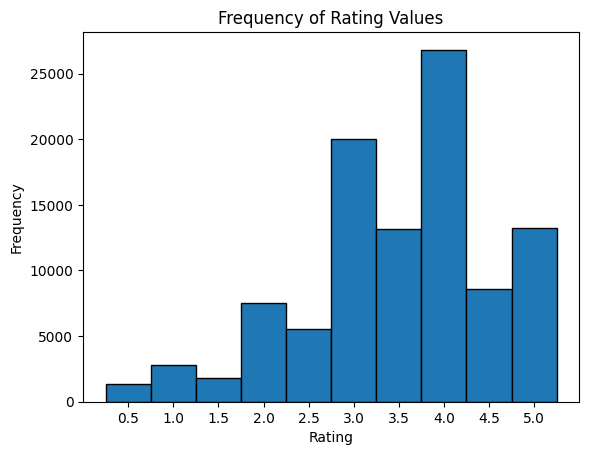

In [ ]:
plt.hist(df_rating['rating'], bins=np.arange(0.25, 5.75, 0.5), edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Rating Values')
plt.xticks(np.arange(0.5, 5.5, 0.5))  # Ensure x-ticks match the bins
plt.show()

##C

In [ ]:
user_rating_counts = df_rating['movieId'].value_counts()
user_rating_counts

356       329
318       317
296       307
593       279
2571      278
         ... 
165959      1
88069       1
4925        1
112512      1
6101        1
Name: movieId, Length: 9724, dtype: int64

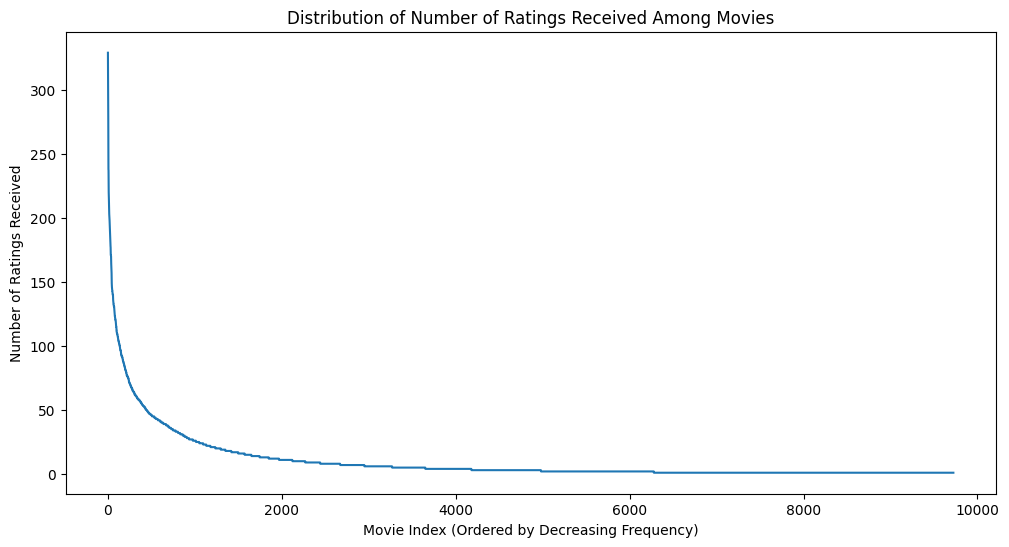

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(user_rating_counts.values)
plt.title('Distribution of Number of Ratings Received Among Movies')
plt.xlabel('Movie Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Ratings Received')
plt.show()

##D

In [ ]:
user_rating_counts = df_rating['userId'].value_counts()
user_rating_counts

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
257      20
595      20
207      20
320      20
442      20
Name: userId, Length: 610, dtype: int64

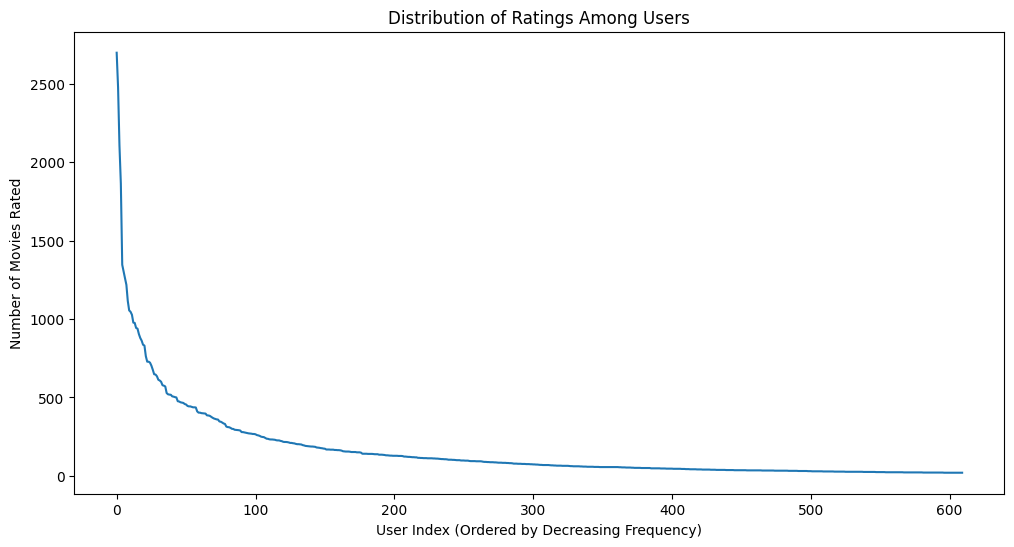

In [ ]:
# Assuming user_rating_counts contains the count of ratings per user, sorted by decreasing frequency
plt.figure(figsize=(12, 6))
plt.plot(user_rating_counts.values)
plt.title('Distribution of Ratings Among Users')
plt.xlabel('User Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Movies Rated')
plt.show()


##E

For both user and movie, the smaller the index, the higher the number of the ratings. It implies a small number of users and movies give or receive disproportionately high number of ratings.

##F

The graph has a right-skewed distribution.

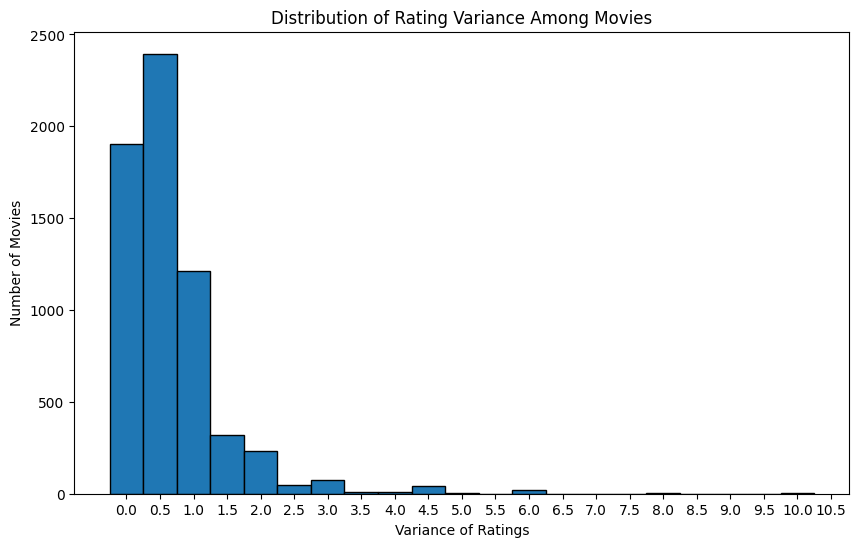

In [ ]:
variance_ratings_per_movie = df_rating.groupby('movieId')['rating'].var()
bins = np.arange(0, variance_ratings_per_movie.max() + 0.5, 0.5)
variance_hist, bin_edges = np.histogram(variance_ratings_per_movie, bins=bins)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], variance_hist, width=0.5, edgecolor='black')
plt.xlabel('Variance of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Rating Variance Among Movies')
plt.xticks(bins)
plt.show()

#Q2

##A

$$
\mu_u = \frac{1}{|I_u|} \sum_{k \in I_u} r_{uk}
$$


##B

$I_u$ and $I_v$ means between set of items indices rating by both user u and user v. It could be an empty set user v and user u rate on completely diffrerent movies.

#Q3

So basically we are using user v to predict the rating for user u. Person score is the correlation coefficients, if's between -1 to 1, representing negative relationship or positive relationship. $r_{vj}$ - $\mu_v$ is to see the importance level or satisfaction level of item j felt by user v. This adjust for different rating habits for different users(some user may rate on average 3, while some other users may rate on average 4.5), so that we can extract feature more accurately.

#Q4

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

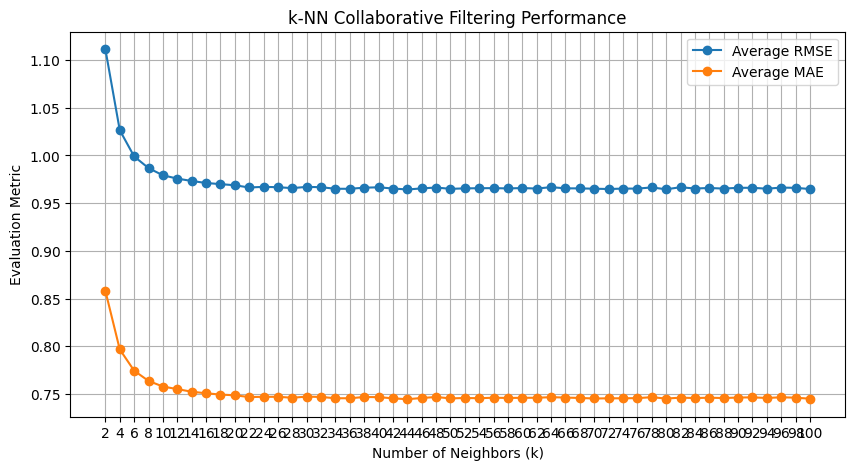

In [ ]:
# Setup the reader with the correct rating scale
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=10)
k_values = range(2, 101, 2)  # k from 2 to 100 in steps of 2
average_rmse = []
average_mae = []
for k in k_values:
    algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})

    # Perform cross-validation
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=False)

    # Store the average RMSE and MAE
    average_rmse.append(np.mean(results['test_rmse']))
    average_mae.append(np.mean(results['test_mae']))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(k_values, average_rmse, 'o-', label='Average RMSE')
plt.plot(k_values, average_mae, 'o-', label='Average MAE')
plt.title('k-NN Collaborative Filtering Performance')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Evaluation Metric')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

#Q5

The k is 18. The steady steate of RMSE is 0.97,and the steady state for MAE is 0.75.

#Q6

In [ ]:
def no_trim(df):
  return df
def trim_popular(df):
    """Trim dataset to only include movies with more than 2 ratings."""
    movie_counts = df['movieId'].value_counts()
    popular_movies = movie_counts[movie_counts > 2].index
    return df[df['movieId'].isin(popular_movies)]

def trim_unpopular(df):
    """Trim dataset to only include movies with 2 or fewer ratings."""
    movie_counts = df['movieId'].value_counts()
    unpopular_movies = movie_counts[movie_counts <= 2].index
    return df[df['movieId'].isin(unpopular_movies)]

def trim_high_variance(df):
    """Trim dataset to include movies with variance of at least 2 in rating,
    and at least 5 ratings."""
    movie_stats = df.groupby('movieId')['rating'].agg(['var', 'count'])
    high_variance_movies = movie_stats[(movie_stats['var'] >= 2) & (movie_stats['count'] >= 5)].index
    return df[df['movieId'].isin(high_variance_movies)]

Best K for trim-popular is 25.
<br> Best K for

In [ ]:
# Assuming df_rating is your DataFrame and the trimming functions are defined
trimmed_df_popular = trim_popular(df_rating)
data_popular = Dataset.load_from_df(trimmed_df_popular[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)
average_rmse_popular = []

for k in range(2, 101, 2):
    algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
    results = cross_validate(algo, data_popular, measures=['RMSE'], cv=kf, verbose=False)
    average_rmse_popular.append(np.mean(results['test_rmse']))



Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [ ]:
trimmed_df_unpopular = trim_unpopular(df_rating)
data_unpopular = Dataset.load_from_df(trimmed_df_unpopular[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=10)
average_rmse_unpopular = []

for k in range(2, 101, 2):
    algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
    results = cross_validate(algo, data_unpopular, measures=['RMSE'], cv=kf, verbose=False)
    average_rmse_unpopular.append(np.mean(results['test_rmse']))




Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [ ]:
trimmed_df_high_variance = trim_high_variance(df_rating)
data_high_variance = Dataset.load_from_df(trimmed_df_high_variance[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=10)
average_rmse_high_variance = []
k_values = range(2, 101, 2)  # k from 2 to 100 in steps of 2


for k in k_values:
    algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
    # Perform cross-validation
    results = cross_validate(algo, data_high_variance, measures=['RMSE'], cv=kf, verbose=False)
    # Calculate and store the average RMSE
    average_rmse_high_variance.append(np.mean(results['test_rmse']))


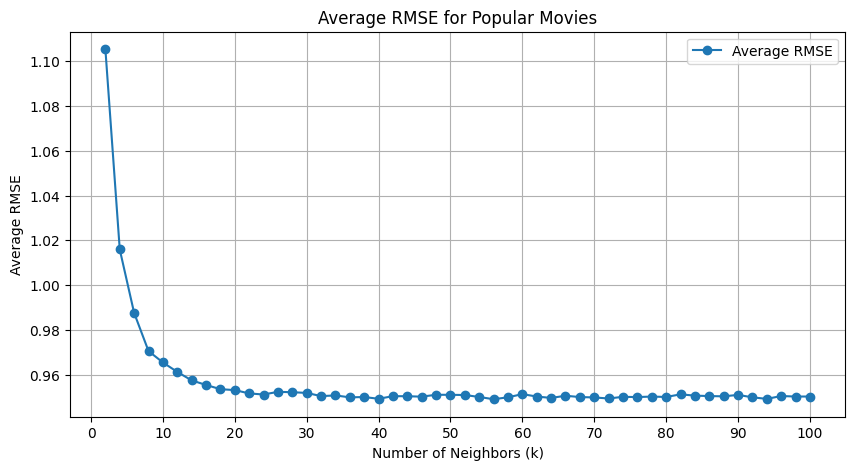

Minimum Average RMSE (Popular Movies): 0.9489977177052153, Best k: 56


In [ ]:
# Plotting RMSE for Popular Movies
plt.figure(figsize=(10, 5))
plt.plot(range(2, 101, 2), average_rmse_popular, 'o-', label='Average RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Popular Movies')
plt.xticks(np.arange(0, 101, 10))
plt.legend()
plt.grid(True)
plt.show()

# Record the minimum average RMSE for popular movies
min_rmse_popular = min(average_rmse_popular)
best_k_popular = range(2, 101, 2)[average_rmse_popular.index(min_rmse_popular)]
print(f'Minimum Average RMSE (Popular Movies): {min_rmse_popular}, Best k: {best_k_popular}')

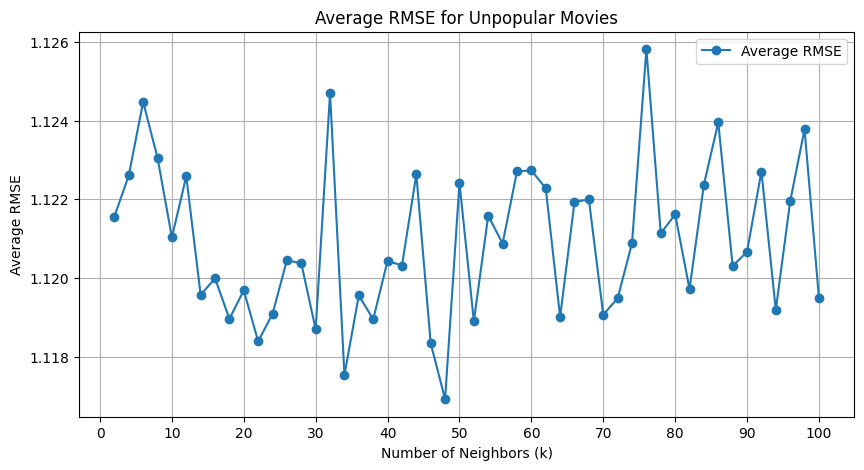

Minimum Average RMSE (Unpopular Movies): 1.1169162046455818, Best k: 48


In [ ]:
# Plotting RMSE for unpopular Movies
plt.figure(figsize=(10, 5))
plt.plot(range(2, 101, 2), average_rmse_unpopular, 'o-', label='Average RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Unpopular Movies')
plt.xticks(np.arange(0, 101, 10))
plt.legend()
plt.grid(True)
plt.show()

# Record the minimum average RMSE for unpopular movies
min_rmse_unpopular = min(average_rmse_unpopular)
best_k_unpopular = range(2, 101, 2)[average_rmse_unpopular.index(min_rmse_unpopular)]
print(f'Minimum Average RMSE (Unpopular Movies): {min_rmse_unpopular}, Best k: {best_k_unpopular}')

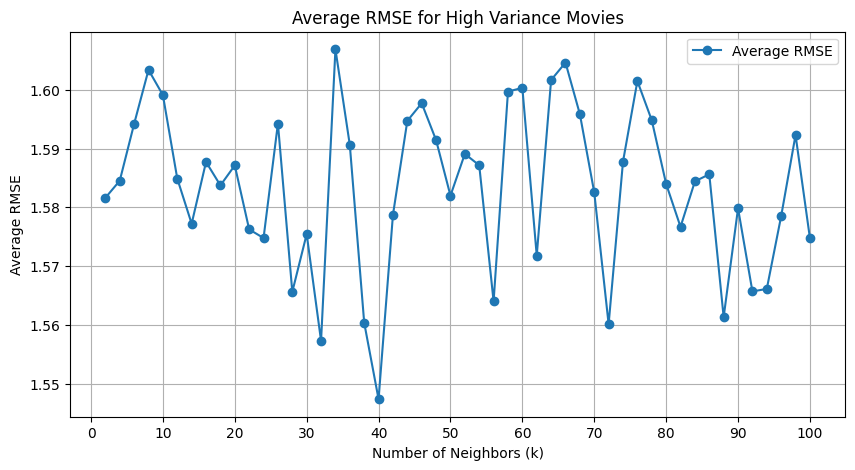

Minimum Average RMSE for High Variance Movies: 1.5474 at k = 40


In [ ]:
# Plotting the RMSE results for High Variance Movies
plt.figure(figsize=(10, 5))
plt.plot(k_values, average_rmse_high_variance, 'o-', label='Average RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for High Variance Movies')
plt.xticks(np.arange(0, 101, 10))
plt.legend()
plt.grid(True)
plt.show()

# Find the minimum average RMSE and corresponding k value
min_rmse_value = min(average_rmse_high_variance)
best_k_value = k_values[average_rmse_high_variance.index(min_rmse_value)]
print(f"Minimum Average RMSE for High Variance Movies: {min_rmse_value:.4f} at k = {best_k_value}")

In [ ]:
def plot_roc_curves(actual, predictions, thresholds, title):
    plt.figure(figsize=(10, 8))

    for threshold in thresholds:
        # Binarize the output (ground truth) based on the threshold
        binarized_actual = [1 if rating > threshold else 0 for rating in actual]

        # Compute ROC curve and ROC area for each threshold
        fpr, tpr, _ = roc_curve(binarized_actual, predictions)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Threshold = {threshold} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves: {title}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_roc_curves(data, k, trim_name, thresholds=[2.5, 3, 3.5, 4]):
    trainset, testset = train_test_split(data, test_size=.10)
    algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
    algo.fit(trainset)
    predictions = algo.test(testset)

    plt.figure(figsize=(10, 8))
    for threshold in thresholds:
        true_binary = [binarize_ratings(pred.r_ui, threshold) for pred in predictions]
        scores = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(true_binary, scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Threshold = {threshold} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {trim_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
def binarize_ratings(rating, threshold):
    return 1 if rating > threshold else 0

Computing the pearson similarity matrix...
Done computing similarity matrix.


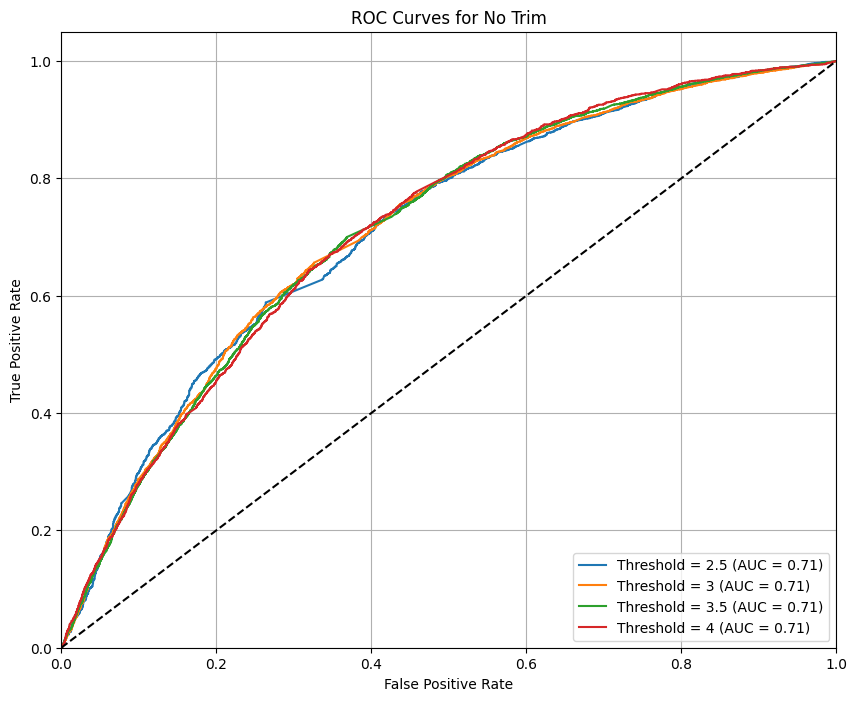

Computing the pearson similarity matrix...
Done computing similarity matrix.


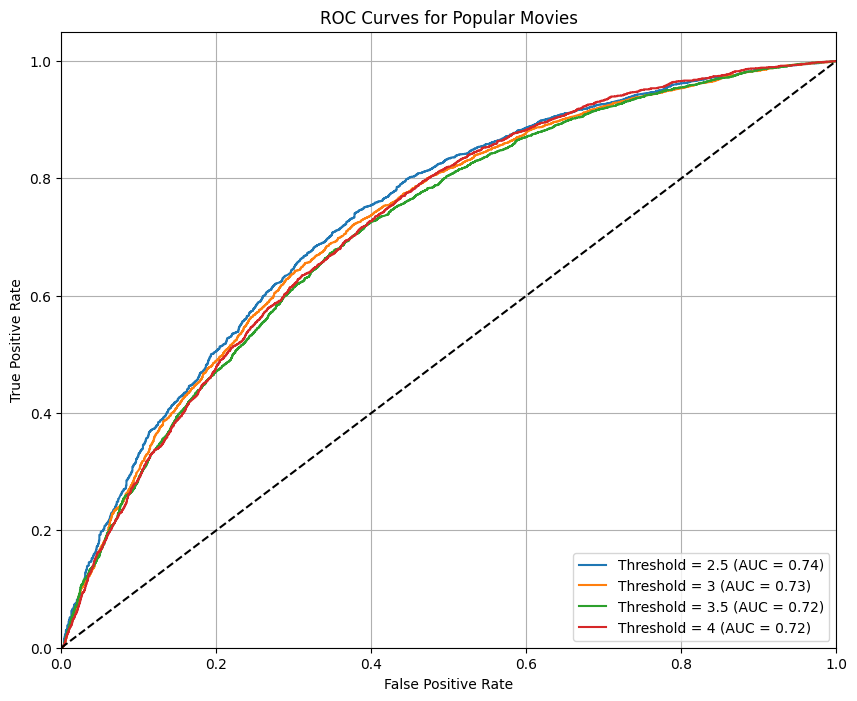

Computing the pearson similarity matrix...
Done computing similarity matrix.


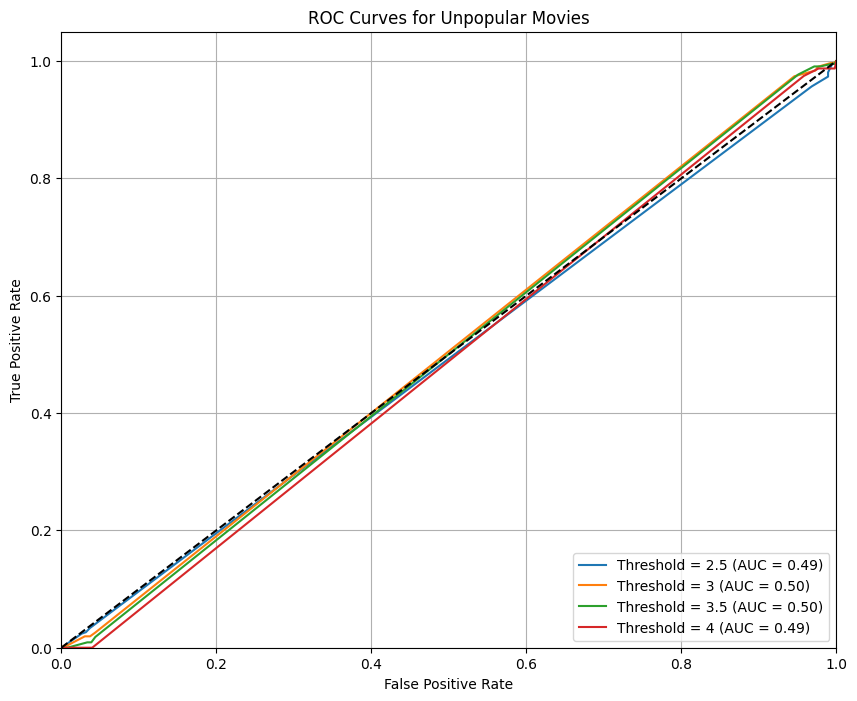

Computing the pearson similarity matrix...
Done computing similarity matrix.


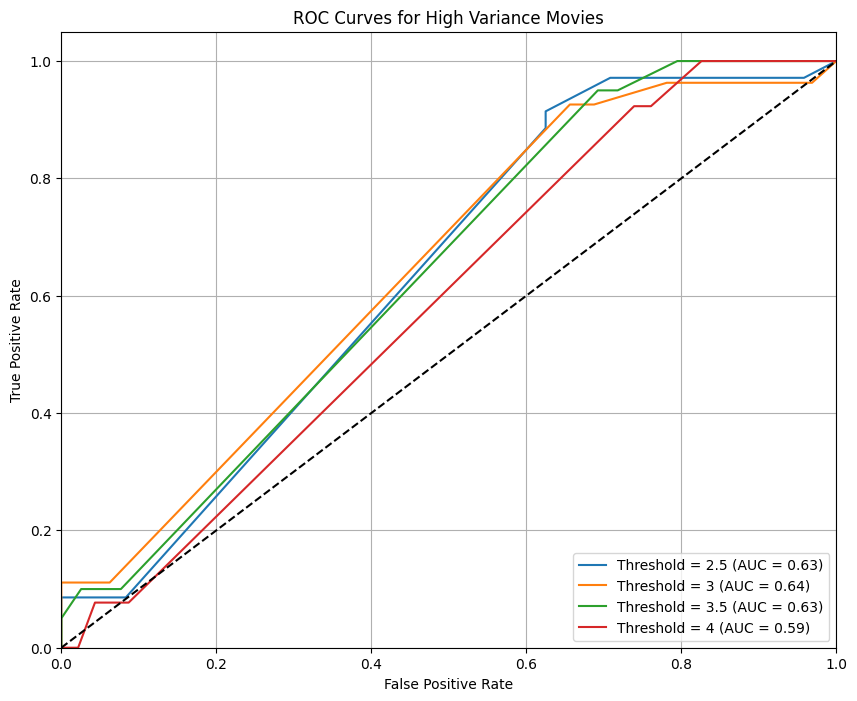

In [ ]:
# Assuming df_rating is your DataFrame and the trimming functions are defined
reader = Reader(rating_scale=(0, 5))
k_values = {'No Trim': 18, 'Popular Movies': 22, 'Unpopular Movies': 48, 'High Variance Movies': 40}
trim_functions = [no_trim, trim_popular, trim_unpopular, trim_high_variance]
trim_names = ['No Trim', 'Popular Movies', 'Unpopular Movies', 'High Variance Movies']

# Assuming the definition of binarize_ratings function is available

for trim_function, trim_name in zip(trim_functions, trim_names):
    trimmed_df = trim_function(df_rating)
    data = Dataset.load_from_df(trimmed_df[['userId', 'movieId', 'rating']], reader)
    plot_roc_curves(data, k_values[trim_name], trim_name)

#Q7

For equation5, if both U and V are variable, then it is non convex. If U is fixed, or V is fixed, then it turned to a convex problem.
<br>$$
\text{Min } V: \quad \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij} \left(r_{ij} - \left(U_{i} V_{j}^{T}\right)\right)^2
$$

#Q8

##A

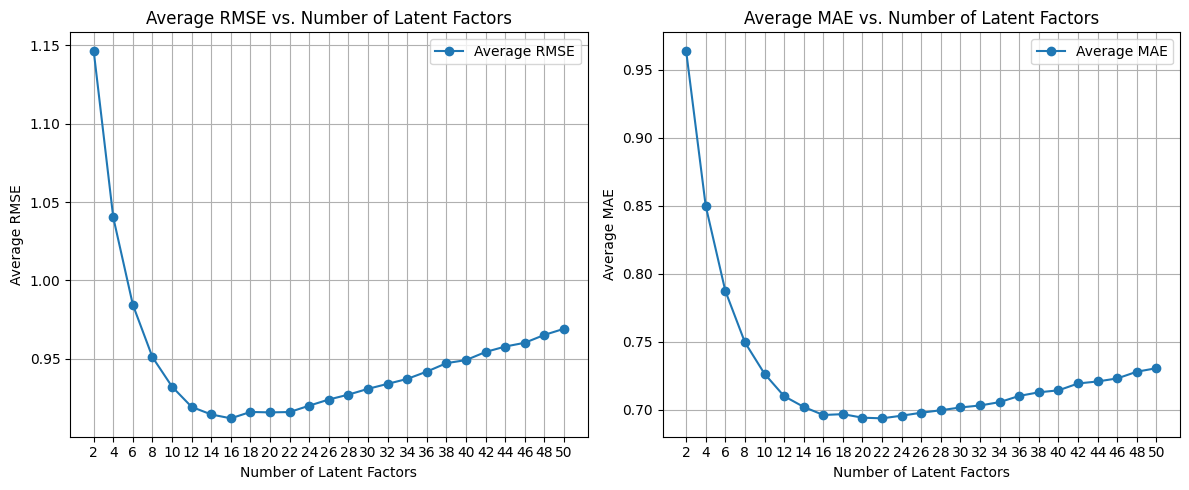

In [7]:
# Assuming df_rating is your DataFrame containing ['userId', 'movieId', 'rating']
reader = Reader(rating_scale=(0, 5))  # Adjust based on your dataset's rating scale
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

# Sweep k (number of latent factors) from 2 to 50 in step sizes of 2
latent_factors = range(2, 51, 2)
avg_rmses = []
avg_maes = []

for k in latent_factors:
    algo = NMF(n_factors=k)
    # Perform 10-fold cross-validation
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    # Store the average RMSE and MAE
    avg_rmses.append(np.mean(results['test_rmse']))
    avg_maes.append(np.mean(results['test_mae']))

# Plotting the average RMSE and MAE against k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(latent_factors, avg_rmses, label='Average RMSE', marker='o')
plt.title('Average RMSE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Average RMSE')
plt.xticks(latent_factors)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(latent_factors, avg_maes, label='Average MAE', marker='o')
plt.title('Average MAE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Average MAE')
plt.xticks(latent_factors)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Optimal k for RMSE: 18 with RMSE: 0.9133354859463576
<br>Optimal k for MAE: 18 with MAE: 0.6945111223340301
<br> Movie has 19 genres, but k = 18, so not same but very close.

In [ ]:
trimmed_df_popular = trim_popular(df_rating)
data_popular = Dataset.load_from_df(trimmed_df_popular[['userId', 'movieId', 'rating']], reader)

# Initialize list for tracking RMSEs
avg_rmses_popular = []
ks = range(2, 51, 2)  # Number of latent factors

# Evaluate NMF for each k
for k in ks:
    algo = NMF(n_factors=k)
    cv_results = cross_validate(algo, data_popular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmses_popular.append(np.mean(cv_results['test_rmse']))



In [ ]:
# Trim dataset for Unpopular Movies
trimmed_df_unpopular = trim_unpopular(df_rating)
data_unpopular = Dataset.load_from_df(trimmed_df_unpopular[['userId', 'movieId', 'rating']], reader)

# Initialize list for tracking RMSEs
avg_rmses_unpopular = []

# Evaluate NMF for each k
for k in ks:
    algo = NMF(n_factors=k)
    cv_results = cross_validate(algo, data_unpopular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmses_unpopular.append(np.mean(cv_results['test_rmse']))



In [ ]:
# Trim dataset for High-Variance Movies
trimmed_df_high_variance = trim_high_variance(df_rating)
data_high_variance = Dataset.load_from_df(trimmed_df_high_variance[['userId', 'movieId', 'rating']], reader)

# Initialize list for tracking RMSEs
avg_rmses_high_variance = []

# Evaluate NMF for each k
for k in ks:
    algo = NMF(n_factors=k)
    cv_results = cross_validate(algo, data_high_variance, measures=['RMSE'], cv=10, verbose=False)
    avg_rmses_high_variance.append(np.mean(cv_results['test_rmse']))

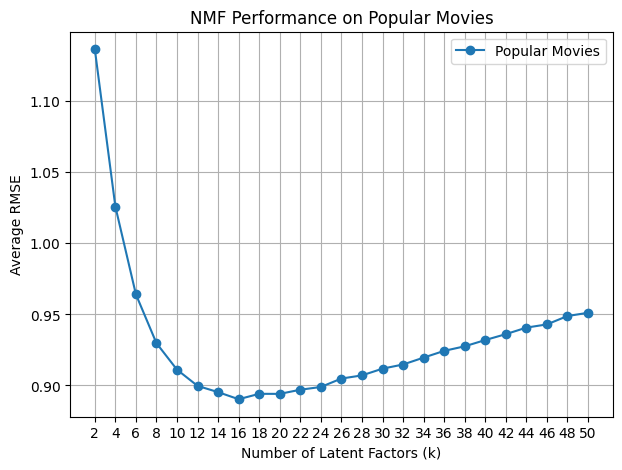

Popular Movies: Min Avg RMSE: 0.8903 at k=16


In [ ]:
# Plotting RMSE for Popular Movies
plt.figure(figsize=(7, 5))
plt.plot(ks, avg_rmses_popular, marker='o', label='Popular Movies')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('NMF Performance on Popular Movies')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

# Minimum average RMSE
min_rmse_popular = min(avg_rmses_popular)
optimal_k_popular = ks[avg_rmses_popular.index(min_rmse_popular)]
print(f"Popular Movies: Min Avg RMSE: {min_rmse_popular:.4f} at k={optimal_k_popular}")

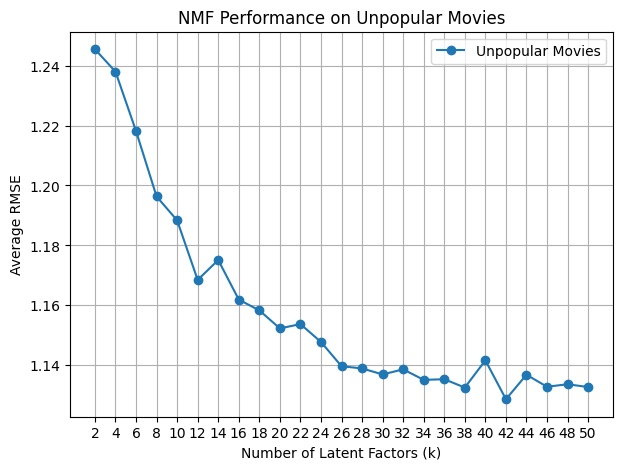

Unpopular Movies: Min Avg RMSE: 1.1287 at k=42


In [ ]:
# Plotting RMSE for Unpopular Movies
plt.figure(figsize=(7, 5))
plt.plot(ks, avg_rmses_unpopular, marker='o', label='Unpopular Movies')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('NMF Performance on Unpopular Movies')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

# Minimum average RMSE
min_rmse_unpopular = min(avg_rmses_unpopular)
optimal_k_unpopular = ks[avg_rmses_unpopular.index(min_rmse_unpopular)]
print(f"Unpopular Movies: Min Avg RMSE: {min_rmse_unpopular:.4f} at k={optimal_k_unpopular}")

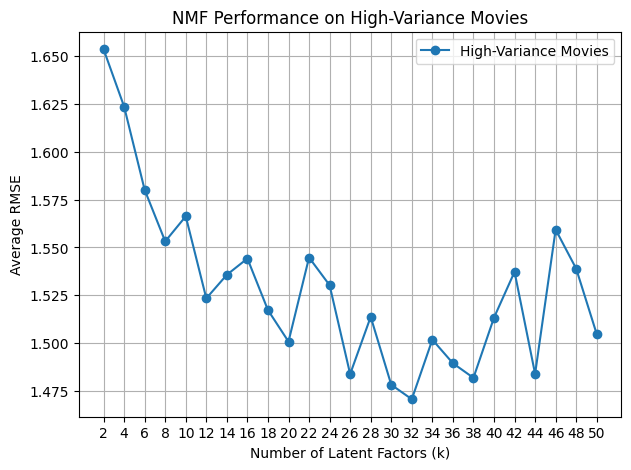

High-Variance Movies: Min Avg RMSE: 1.4707 at k=32


In [ ]:
# Plotting RMSE for High-Variance Movies
plt.figure(figsize=(7, 5))
plt.plot(ks, avg_rmses_high_variance, marker='o', label='High-Variance Movies')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('NMF Performance on High-Variance Movies')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

# Minimum average RMSE
min_rmse_high_variance = min(avg_rmses_high_variance)
optimal_k_high_variance = ks[avg_rmses_high_variance.index(min_rmse_high_variance)]
print(f"High-Variance Movies: Min Avg RMSE: {min_rmse_high_variance:.4f} at k={optimal_k_high_variance}")

## B

In [ ]:
def plot_roc_curves(data, k, trim_name, thresholds=[2.5, 3, 3.5, 4]):
    trainset, testset = train_test_split(data, test_size=.10)
    algo = NMF(n_factors=k)
    algo.fit(trainset)
    predictions = algo.test(testset)

    plt.figure(figsize=(10, 8))
    for threshold in thresholds:
        true_binary = [binarize_ratings(pred.r_ui, threshold) for pred in predictions]
        scores = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(true_binary, scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Threshold = {threshold} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {trim_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
def binarize_ratings(rating, threshold):
    return 1 if rating > threshold else 0

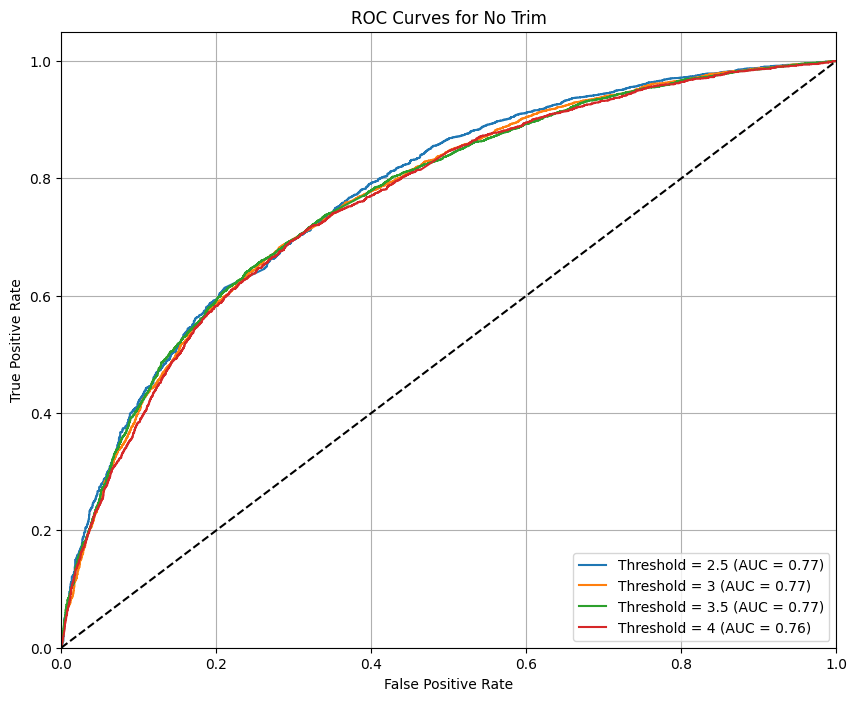

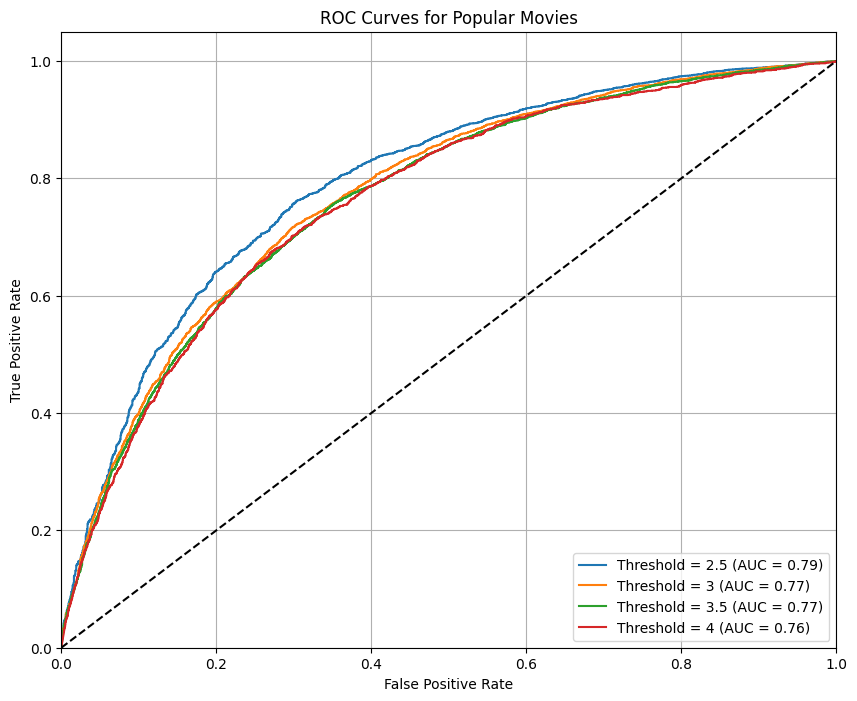

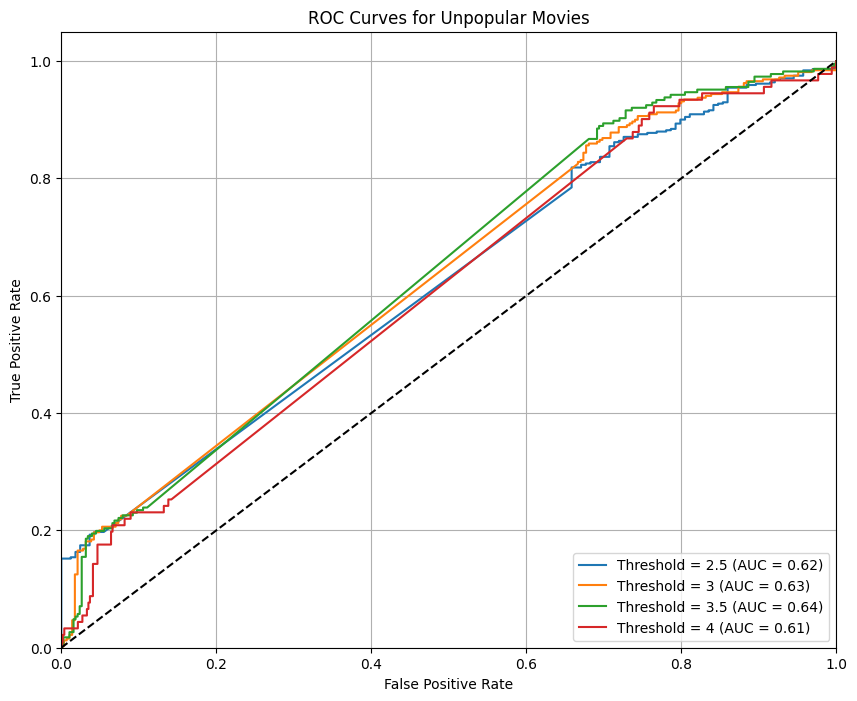

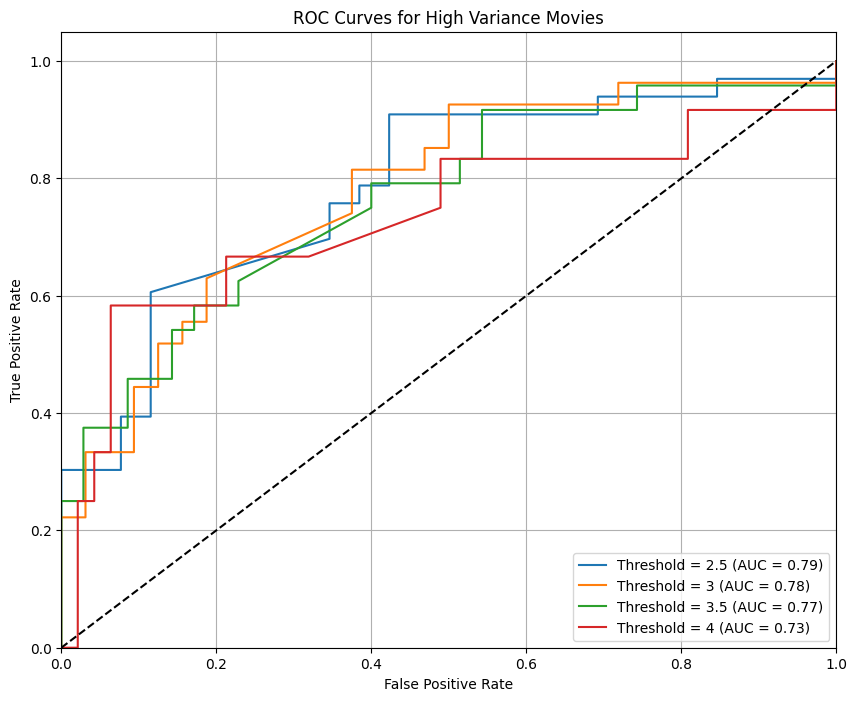

In [ ]:
# Assuming df_rating is your DataFrame and the trimming functions are defined
reader = Reader(rating_scale=(0, 5))
k_values = {'No Trim': 18, 'Popular Movies': 16, 'Unpopular Movies': 38, 'High Variance Movies': 32}
trim_functions = [no_trim, trim_popular, trim_unpopular, trim_high_variance]
trim_names = ['No Trim', 'Popular Movies', 'Unpopular Movies', 'High Variance Movies']

# Assuming the definition of binarize_ratings function is available

for trim_function, trim_name in zip(trim_functions, trim_names):
    trimmed_df = trim_function(df_rating)
    data = Dataset.load_from_df(trimmed_df[['userId', 'movieId', 'rating']], reader)
    plot_roc_curves(data, k_values[trim_name], trim_name)

#Q9

In [ ]:
R_df = df_rating.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the DataFrame to a sparse matrix
R = csr_matrix(R_df.values)

In [ ]:
print(R)

  (0, 0)	4.0
  (0, 2)	4.0
  (0, 5)	4.5
  (0, 43)	5.0
  (0, 46)	5.0
  (0, 62)	2.5
  (0, 89)	5.0
  (0, 97)	4.5
  (0, 124)	5.0
  (0, 130)	5.0
  (0, 136)	5.0
  (0, 184)	5.0
  (0, 190)	3.0
  (0, 197)	5.0
  (0, 201)	4.0
  (0, 224)	5.0
  (0, 257)	3.0
  (0, 275)	3.0
  (0, 291)	5.0
  (0, 307)	4.0
  (0, 314)	4.0
  (0, 320)	5.0
  (0, 325)	4.0
  (0, 367)	3.0
  (0, 384)	4.0
  :	:
  (609, 9238)	5.0
  (609, 9246)	4.5
  (609, 9256)	4.0
  (609, 9268)	5.0
  (609, 9274)	3.5
  (609, 9279)	3.5
  (609, 9282)	3.0
  (609, 9288)	3.0
  (609, 9304)	3.0
  (609, 9307)	2.5
  (609, 9312)	4.5
  (609, 9317)	3.0
  (609, 9324)	3.0
  (609, 9339)	4.0
  (609, 9341)	4.0
  (609, 9348)	3.5
  (609, 9371)	3.5
  (609, 9372)	3.5
  (609, 9374)	5.0
  (609, 9415)	4.0
  (609, 9416)	4.0
  (609, 9443)	5.0
  (609, 9444)	5.0
  (609, 9445)	5.0
  (609, 9485)	3.0


In [ ]:
from sklearn.decomposition import NMF


In [ ]:
nmf = NMF(n_components=20, init='random', random_state=42)
W = nmf.fit_transform(R)  # User-latent factors matrix (U)
H = nmf.components_

In [ ]:
# Assuming 'movie_ids' is a list of movie IDs corresponding to columns in R
# and 'df_movies' is your DataFrame with columns ['movieId', 'title', 'genres']

def get_top_movies_for_factor(factor_index, H, movie_ids, df_movie, top_n=10):
    # Get the movie weights for the factor
    factor_weights = H[factor_index, :]
    # Get indices of the top movies
    top_movie_indices = np.argsort(factor_weights)[-top_n:][::-1]
    # Get corresponding movie IDs
    top_movie_ids = [movie_ids[i] for i in top_movie_indices]
    # Fetch movie titles and genres
    top_movies = df_movie[df_movie['movieId'].isin(top_movie_ids)]
    # Ensure the order is correct
    top_movies = top_movies.set_index('movieId').loc[top_movie_ids].reset_index()
    return top_movies

# Example for the first two factors
for i in range(3,5):
    top_movies = get_top_movies_for_factor(i, H, list(R_df.columns), df_movie)
    print(f"Top 10 movies for latent factor {i+1}:")
    print(top_movies[['title', 'genres']], "\n")


Top 10 movies for latent factor 4:
                                               title  \
0                                 About a Boy (2002)   
1      Lord of the Rings: The Two Towers, The (2002)   
2  Lord of the Rings: The Return of the King, The...   
3                            Schindler's List (1993)   
4                            Chariots of Fire (1981)   
5  Lord of the Rings: The Fellowship of the Ring,...   
6                    Star Trek: First Contact (1996)   
7                               Graduate, The (1967)   
8  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...   
9                                Spider-Man 2 (2004)   

                             genres  
0              Comedy|Drama|Romance  
1                 Adventure|Fantasy  
2    Action|Adventure|Drama|Fantasy  
3                         Drama|War  
4                             Drama  
5                 Adventure|Fantasy  
6  Action|Adventure|Sci-Fi|Thriller  
7              Comedy|Drama|Romance  
8     

No, top 10 movies are not belong to a small genre. However, it shows a strong correlation between latend factor and title genres. For latent factor 4, most movies belong to Romance and Fantasy. It seems this latent factor may represent the rating from girls. However, for latent factor 5, most films belong to horror, sci-fi, thriller. This indicates this latent factor may represent movie rating from boys.

#Q10

## A

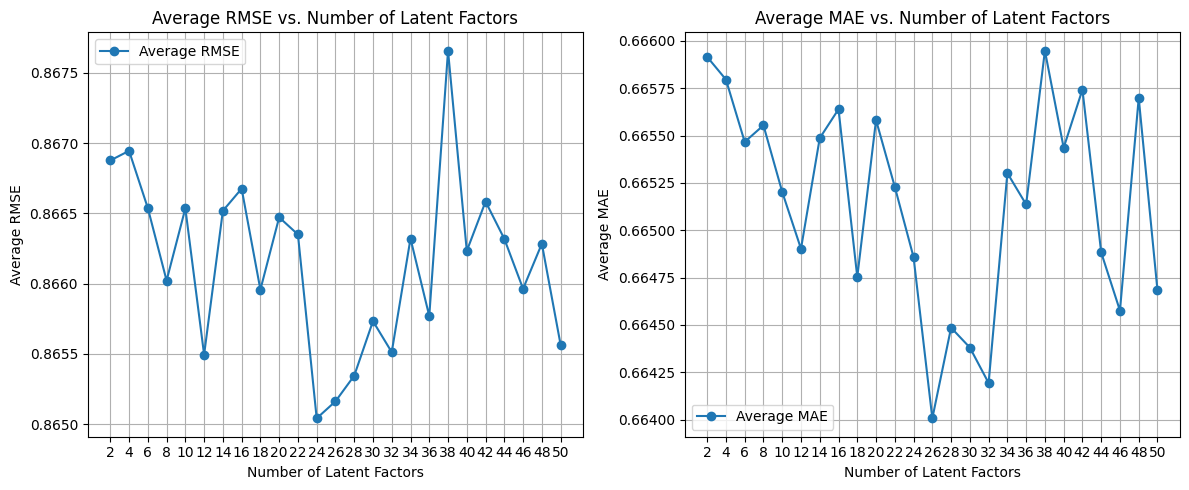

In [ ]:
from surprise import SVD
# Assuming df_rating is your DataFrame containing ['userId', 'movieId', 'rating']
reader = Reader(rating_scale=(0, 5))  # Adjust based on your dataset's rating scale
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

# Sweep k (number of latent factors) from 2 to 50 in step sizes of 2
latent_factors = range(2, 51, 2)
avg_rmses = []
avg_maes = []

for k in latent_factors:
    algo = SVD(n_factors=k)
    # Perform 10-fold cross-validation
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    # Store the average RMSE and MAE
    avg_rmses.append(np.mean(results['test_rmse']))
    avg_maes.append(np.mean(results['test_mae']))

# Plotting the average RMSE and MAE against k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(latent_factors, avg_rmses, label='Average RMSE', marker='o')
plt.title('Average RMSE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Average RMSE')
plt.xticks(latent_factors)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(latent_factors, avg_maes, label='Average MAE', marker='o')
plt.title('Average MAE vs. Number of Latent Factors')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Average MAE')
plt.xticks(latent_factors)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## B

The minimum RMSE is 0.87 at 24, and the minimum average MAE is 0.664 at 26. It's not same as the number of genres as number of genres is 19.

## C

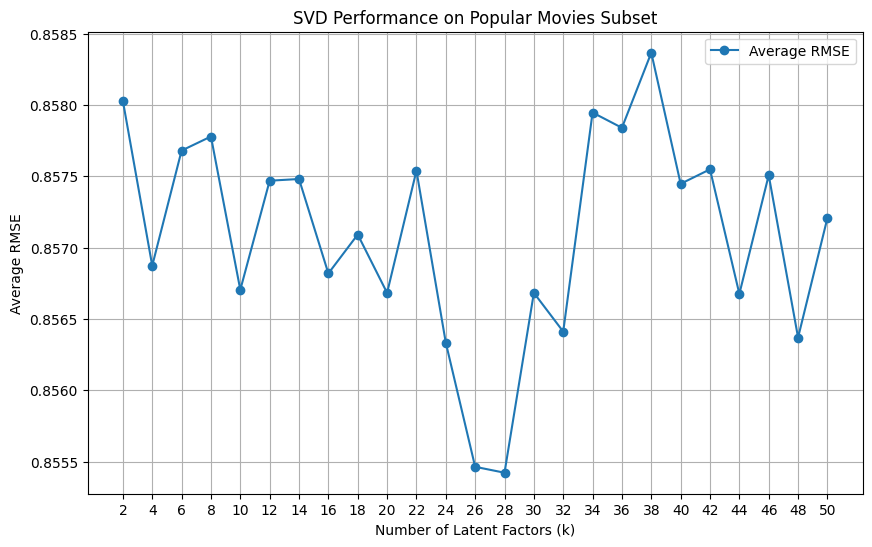

In [ ]:
# Assuming df_rating is your DataFrame containing ['userId', 'movieId', 'rating']
reader = Reader(rating_scale=(1, 5))  # Adjust based on your dataset's rating scale

# Function to evaluate SVD on a given dataset
def evaluate_svd(data, k_values):
    avg_rmses = []
    for k in k_values:
        algo = SVD(n_factors=k)
        # Perform 10-fold cross-validation
        results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=False)
        # Store the average RMSE
        avg_rmses.append(np.mean(results['test_rmse']))
    return avg_rmses

# Function to plot RMSE vs. k
def plot_rmse_k(k_values, avg_rmses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_rmses, marker='o', label='Average RMSE')
    plt.title(title)
    plt.xlabel('Number of Latent Factors (k)')
    plt.ylabel('Average RMSE')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example for the popular movies subset
k_values = range(2, 51, 2)
trimmed_df = trim_popular(df_rating)  # Use your trimming function
data_popular = Dataset.load_from_df(trimmed_df[['userId', 'movieId', 'rating']], reader)
avg_rmses_popular = evaluate_svd(data_popular, k_values)
plot_rmse_k(k_values, avg_rmses_popular, 'SVD Performance on Popular Movies Subset')


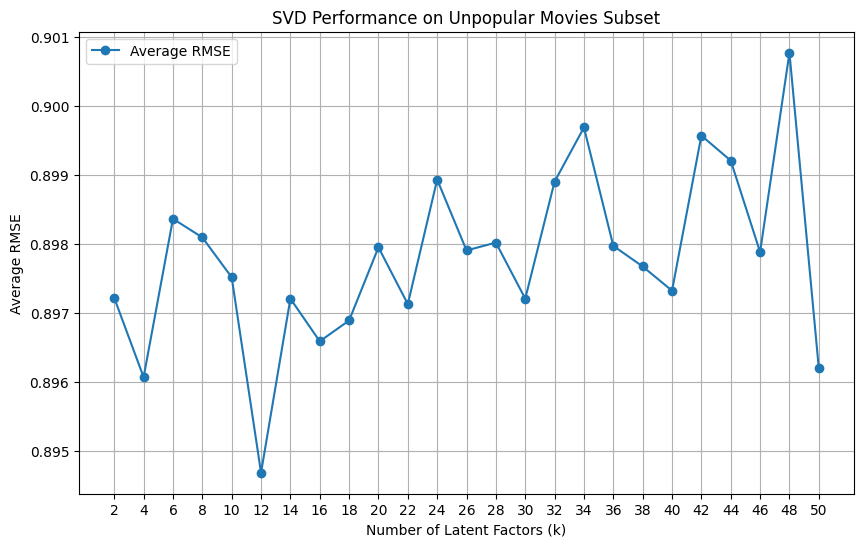

In [ ]:
trimmed_df = trim_unpopular(df_rating)  # Use your trimming function
data_unpopular = Dataset.load_from_df(trimmed_df[['userId', 'movieId', 'rating']], reader)
avg_rmses_unpopular = evaluate_svd(data_unpopular, k_values)
plot_rmse_k(k_values, avg_rmses_unpopular, 'SVD Performance on Unpopular Movies Subset')

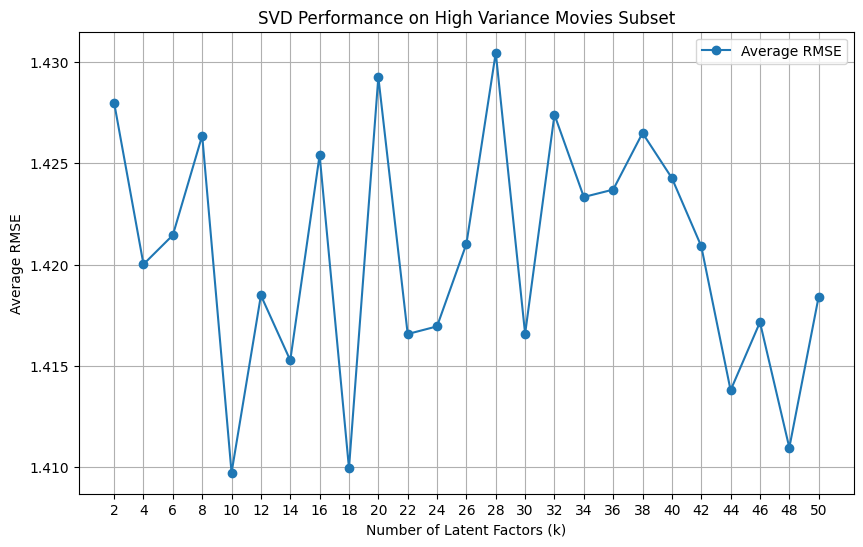

In [ ]:
trimmed_df = trim_high_variance(df_rating)  # Use your trimming function
data_highvar = Dataset.load_from_df(trimmed_df[['userId', 'movieId', 'rating']], reader)
avg_rmses_highvar = evaluate_svd(data_highvar, k_values)
plot_rmse_k(k_values, avg_rmses_highvar, 'SVD Performance on High Variance Movies Subset')

In [ ]:
def plot_roc_curves_mf(data, k, trim_name, thresholds=[2.5, 3, 3.5, 4]):
    trainset, testset = train_test_split(data, test_size=.10)
    algo = SVD(n_factors=k)  # Using SVD for MF with bias
    algo.fit(trainset)
    predictions = algo.test(testset)

    plt.figure(figsize=(10, 8))
    for threshold in thresholds:
        true_binary = [binarize_ratings(pred.r_ui, threshold) for pred in predictions]
        scores = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(true_binary, scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Threshold = {threshold} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {trim_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


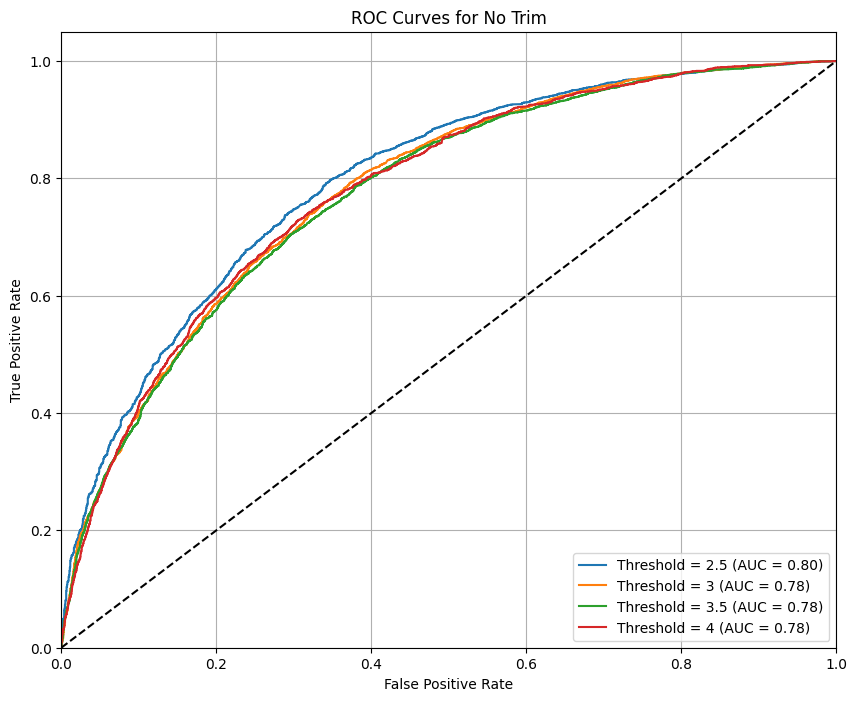

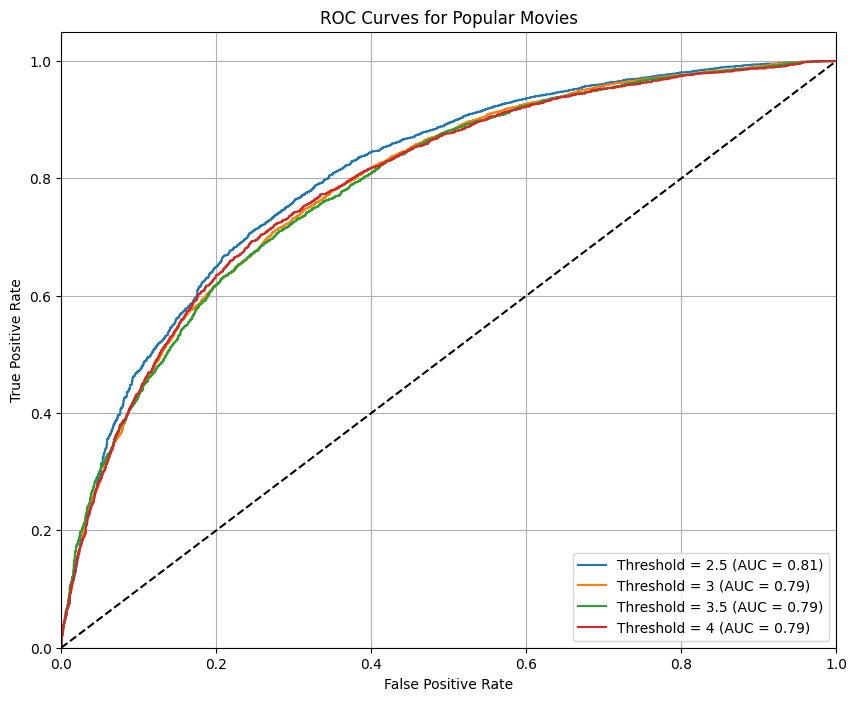

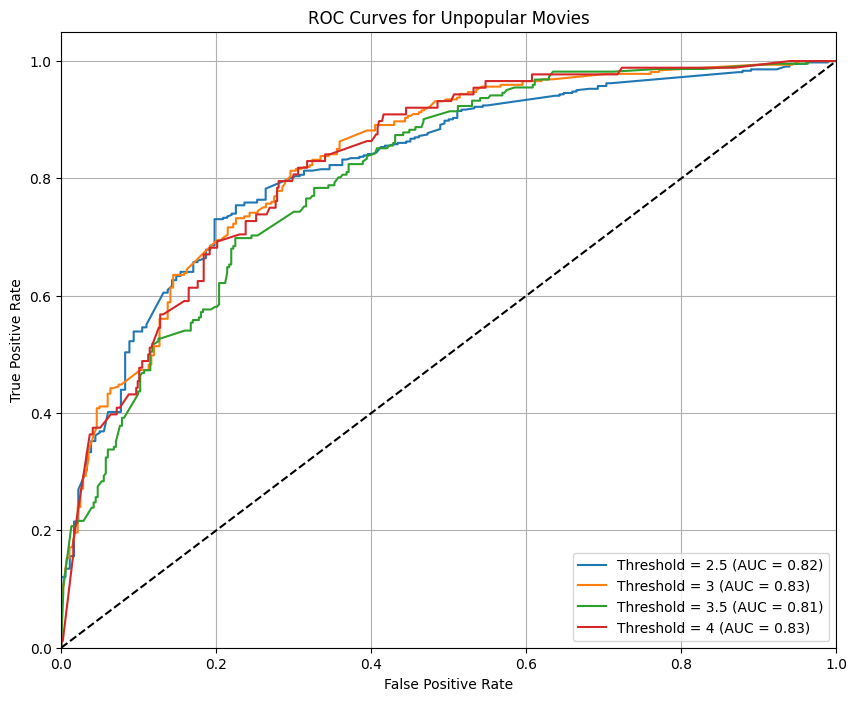

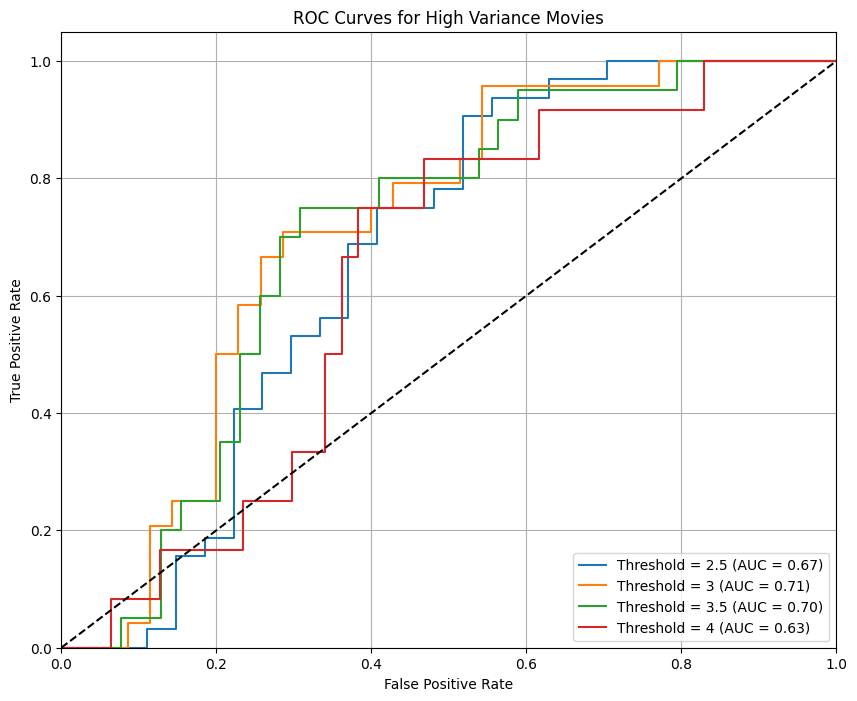

In [ ]:
reader = Reader(rating_scale=(0, 5))
k_values = {
    'No Trim': 26,
    'Popular Movies': 28,
    'Unpopular Movies': 12,
    'High Variance Movies': 10
}
trim_functions = [no_trim, trim_popular, trim_unpopular, trim_high_variance]
trim_names = ['No Trim', 'Popular Movies', 'Unpopular Movies', 'High Variance Movies']


for trim_function, trim_name in zip(trim_functions, trim_names):
    trimmed_df = trim_function(df_rating)  # Make sure to define or replace no_trim appropriately
    data = Dataset.load_from_df(trimmed_df[['userId', 'movieId', 'rating']], reader)
    plot_roc_curves_mf(data, k_values[trim_name], trim_name)

# Q11

In [ ]:
def naive_collaborative_predict(user_ratings, testset):
    # user_ratings is a dictionary where keys are user IDs and values are lists of their ratings
    predictions = []
    for uid, _, _ in testset:
        user_mean = np.mean(user_ratings[uid]) if uid in user_ratings else global_mean
        predictions.append(user_mean)
    return predictions

In [ ]:
# Assuming df_rating is your DataFrame containing ['userId', 'movieId', 'rating']
reader = Reader(rating_scale=(0, 5))  # Adjust based on your dataset's rating scale
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=10)

global_mean = df_rating['rating'].mean()

In [ ]:
from surprise import accuracy
from collections import defaultdict

rmses = []

for trainset, testset in kf.split(data):
    # Prepare user_ratings dictionary
    user_ratings = defaultdict(list)
    for uid, iid, rating in trainset.all_ratings():
        user_ratings[uid].append(rating)

    # Predict ratings for the testset
    predictions = naive_collaborative_predict(user_ratings, testset)

    # Compare with actual ratings
    actual = [rating for (_, _, rating) in testset]
    mse = sum((pred - actual[i]) ** 2 for i, pred in enumerate(predictions)) / len(predictions)
    rmse = np.sqrt(mse)
    rmses.append(rmse)

# Compute average RMSE
average_rmse = np.mean(rmses)
print(f"Average RMSE: {average_rmse:.4f}")

Average RMSE: 1.7496


In [ ]:
# Function to evaluate the naive collaborative filter on a dataset
global_mean = df_rating['rating'].mean()

def evaluate_naive_cf(data):
    kf = KFold(n_splits=10)
    rmse_scores = []

    for trainset, testset in kf.split(data):
        # Compute mean rating for each user in the trainset
        user_means = {}
        for uid, _, rating in trainset.all_ratings():
            raw_uid = trainset.to_raw_uid(uid)
            user_means.setdefault(raw_uid, []).append(rating)
        user_means = {uid: np.mean(ratings) for uid, ratings in user_means.items()}

        # Predict ratings for the testset
        predictions = []
        for uid, _, true_r in testset:
            # Check if the user was seen during training
            if uid in user_means:
                pred_r = user_means[uid]
            else:
                # Use global mean for users not seen during training
                pred_r = global_mean
            predictions.append(pred_r)

        # Calculate RMSE for this fold
        mse = np.mean([(pred - true_r) ** 2 for pred, (_, _, true_r) in zip(predictions, testset)])
        rmse_scores.append(np.sqrt(mse))

    # Average RMSE across all folds
    return np.mean(rmse_scores)

In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)


In [ ]:
# Assuming trim functions are correctly defined
subsets = {
    'Full Dataset': data,
    'Popular Movies': Dataset.load_from_df(trim_popular(df_rating)[['userId', 'movieId', 'rating']], reader),
    'Unpopular Movies': Dataset.load_from_df(trim_unpopular(df_rating)[['userId', 'movieId', 'rating']], reader),
    'High Variance Movies': Dataset.load_from_df(trim_high_variance(df_rating)[['userId', 'movieId', 'rating']], reader)
}

for name, dataset in subsets.items():
    average_rmse = evaluate_naive_cf(dataset)
    print(f"{name}: Average RMSE = {average_rmse:.4f}")

Full Dataset: Average RMSE = 0.9410
Popular Movies: Average RMSE = 0.9375
Unpopular Movies: Average RMSE = 0.8980
High Variance Movies: Average RMSE = 1.4349


Full Dataset: Average RMSE = 0.9410
<br>Popular Movies: Average RMSE = 0.9375
<br>Unpopular Movies: Average RMSE = 0.8980
<br>High Variance Movies: Average RMSE = 1.4349

# Q12

In [1]:
def binarize_ratings(rating, threshold):
    return 1 if rating > threshold else 0

def plot_roc_curve_combined(data, k_values, model_names):
    plt.figure(figsize=(10, 8))
    threshold = 3

    for model_name, k in zip(model_names, k_values):
        if model_name == "KNN":
            algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
        elif model_name == "NMF":
            algo = NMF(n_factors=k)
        elif model_name == "MF":
            algo = SVD(n_factors=k)  # Using SVD for MF with bias

        trainset, testset = train_test_split(data, test_size=.10)
        algo.fit(trainset)
        predictions = algo.test(testset)

        true_binary = [binarize_ratings(pred.r_ui, threshold) for pred in predictions]
        scores = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(true_binary, scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (k={k}, AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves at Threshold = 3')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

Computing the pearson similarity matrix...
Done computing similarity matrix.


NameError: name 'SVD' is not defined

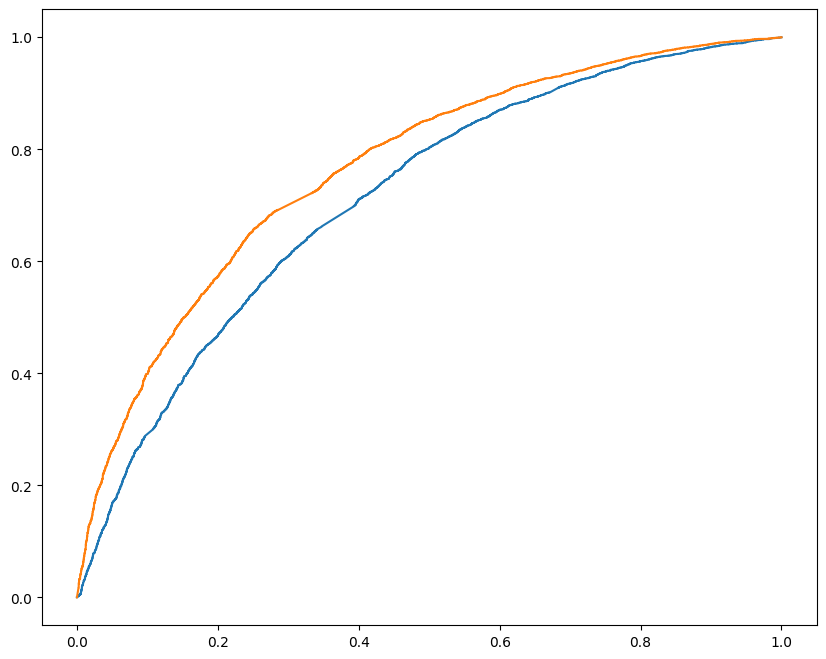

In [6]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

# Optimal k values for each model
k_values = [18, 18, 26]  # Example k values for KNN, NMF, and MF respectively
model_names = ["KNN", "NMF", "MF"]

plot_roc_curve_combined(data, k_values,model_names)

# Q13

In [ ]:
!!pip install lightgbm

['Requirement already satisfied: lightgbm in /usr/local/lib/python3.10/dist-packages (4.1.0)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from lightgbm) (1.25.2)',
 'Requirement already satisfied: scipy in /usr/local/lib/python3.10/dist-packages (from lightgbm) (1.11.4)']

In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.feature_importance(importance_type=importance_type)

In [ ]:
X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = [],[],[],[],[],[],[],[]

In [ ]:
for i in range(0,5):
  X_train_tmp, y_train_tmp, qid_train_tmp, group_train_tmp, X_test_tmp, y_test_tmp, qid_test_tmp, group_test_tmp = load_one_fole(f'drive/MyDrive/ECE219/HW3/MSLR-WEB10K/Fold{i+1}/')
  X_train.append(X_train_tmp)
  y_train.append(y_train_tmp)
  qid_train.append(qid_train_tmp)
  group_train.append(group_train_tmp)
  X_test.append(X_test_tmp)
  y_test.append(y_test_tmp)
  qid_test.append(qid_test_tmp)
  group_test.append(group_test_tmp)

In [ ]:
data_dict = {'X_train': X_train, 'y_train': y_train, 'qid_train': qid_train, 'group_train': group_train, 'X_test': X_test, 'y_test': y_test, 'qid_test': qid_test, 'group_test': group_test}

In [ ]:
import pickle
with open('drive/MyDrive/ECE219/HW3/data_dict.pkl', 'wb') as file:
  pickle.dump(data_dict, file)

In [ ]:
qid = np.hstack(qid_train+qid_test)
unique_queries = np.unique(qid)
print("number of unique queries: ", len(unique_queries))

number of unique queries:  10000


Text(0.5, 1.0, 'Histogram of Label Counts')

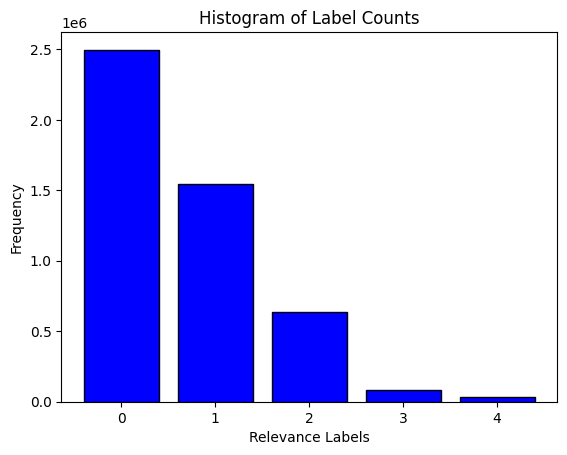

In [ ]:
labels = np.hstack(y_train+y_test)
unique_labels, label_counts = np.unique(labels, return_counts=True)
bins = np.arange(0,5,1)

plt.bar(unique_labels, label_counts, width=0.8, align='center', color='blue', edgecolor='black')

plt.xticks(bins, unique_labels)

plt.xlabel('Relevance Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Label Counts')


# Q14

In [ ]:
import lightgbm

In [ ]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbozse': 1
}

In [ ]:
gbm_zoo = []
for i in range(0,5):
  train_set = lightgbm.Dataset(X_train[i], y_train[i], group=group_train[i])
  test_set = lightgbm.Dataset(X_test[i], y_test[i], group=group_test[i])

  gbm = lightgbm.train(params,
                train_set,
                num_boost_round=100,
                valid_sets=[test_set])
  gbm_zoo.append(gbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.810928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25637
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25623
[LightGBM] [Info] Number of data points in the train set: 716683, number of used features: 136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25659
[LightGBM] [Info] Number of

In [ ]:
for i in range(0,5):
  for k in [3,5,10]:
    score = compute_ndcg_all(gbm_zoo[i], X_test[i], y_test[i], qid_test[i], k)
    print(f'Fold{i+1}: nDCG@{k} = {score}')


Fold1: nDCG@3 = 0.4564571300800643
Fold1: nDCG@5 = 0.4632890672260867
Fold1: nDCG@10 = 0.48286731451235976
Fold2: nDCG@3 = 0.4538895365009714
Fold2: nDCG@5 = 0.4573292117374164
Fold2: nDCG@10 = 0.4767546810011047
Fold3: nDCG@3 = 0.4490681494620125
Fold3: nDCG@5 = 0.4583480538865081
Fold3: nDCG@10 = 0.47589507831078093
Fold4: nDCG@3 = 0.461178820507814
Fold4: nDCG@5 = 0.4663860127875315
Fold4: nDCG@10 = 0.487724614983737
Fold5: nDCG@3 = 0.46963442883961365
Fold5: nDCG@5 = 0.4714315145908388
Fold5: nDCG@10 = 0.49035928048966515


# Q15

In [ ]:
for i in range(0,5):
  result = np.argsort(get_feature_importance(gbm_zoo[i], importance_type='gain'))[-5:] + 1
  print(f'Top 5 most important features of fold{i+1} is {result}')

Top 5 most important features of fold1 is [130  55 108   8 134]
Top 5 most important features of fold2 is [130 108  55   8 134]
Top 5 most important features of fold3 is [  8 130 108  55 134]
Top 5 most important features of fold4 is [129 130  55   8 134]
Top 5 most important features of fold5 is [130 108  55   8 134]


# Q16

In [ ]:
import copy
X_train_20 = copy.deepcopy(X_train)
X_test_20 = copy.deepcopy(X_test)
for i in range(0,5):
  result = np.argsort(get_feature_importance(gbm_zoo[i], importance_type='gain'))[:-20]
  X_train_20[i] = X_train_20[i][:, result]
  X_test_20[i] = X_test_20[i][:, result]

In [ ]:
X_train_20[0].shape

(723412, 116)

In [ ]:
gbm_zoo_20 = []
for i in range(0,5):
  train_set = lightgbm.Dataset(X_train_20[i], y_train[i], group=group_train[i])
  test_set = lightgbm.Dataset(X_test_20[i], y_test[i], group=group_test[i])

  gbm = lightgbm.train(params,
                train_set,
                num_boost_round=100,
                valid_sets=[test_set])

  gbm_zoo_20.append(gbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21582
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21551
[LightGBM] [Info] Number of data points in the train set: 716683, number of used features: 116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21720
[LightGBM] [Info] Number of

In [ ]:
for i in range(0,5):
  # for k in [3,5,10]:
  score = compute_ndcg_all(gbm_zoo_20[i], X_test_20[i], y_test[i], qid_test[i], k=10)
  print(f'Fold{i+1}: nDCG@{k} = {score}')

Fold1: nDCG@10 = 0.4083636029390886
Fold2: nDCG@10 = 0.4045026694861529
Fold3: nDCG@10 = 0.411637205327892
Fold4: nDCG@10 = 0.412099755652924
Fold5: nDCG@10 = 0.4166871494621703


Yes it aligns with my expectation that the nDCG is samller in this case than the nDCG in the case with 136 features. Since the more important features contribute more to the accuracy, deleting those features will lead to a smaller nDCG



In [ ]:
# with open('drive/MyDrive/ECE219/HW3/data_dict.pkl', 'rb') as file:
#   data_dict=pickle.load(file)

In [ ]:
# X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = data_dict.values()

In [ ]:
X_train[i].shape

(722602, 136)

In [ ]:
import copy
X_train_60 = copy.deepcopy(X_train)
X_test_60 = copy.deepcopy(X_test)
for i in range(0,5):
  result = np.argsort(get_feature_importance(gbm_zoo[i], importance_type='gain'))[60:]
  X_train_60[i] = X_train_60[i][:, result]
  X_test_60[i] = X_test_60[i][:, result]

In [ ]:
X_train_60[0].shape

(723412, 76)

In [ ]:
gbm_zoo_60 = []
for i in range(0,5):
  train_set = lightgbm.Dataset(X_train_60[i], y_train[i], group=group_train[i])
  test_set = lightgbm.Dataset(X_test_60[i], y_test[i], group=group_test[i])

  gbm = lightgbm.train(params,
                train_set,
                num_boost_round=100,
                valid_sets=[test_set])

  gbm_zoo_60.append(gbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16271
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 76
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16780
[LightGBM] [Info] Number of data points in the train set: 716683, number of used features: 76
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17029
[LightGBM] [Info] Number of d

In [ ]:
for i in range(0,5):
  # for k in [3,5,10]:
  score = compute_ndcg_all(gbm_zoo_60[i], X_test_60[i], y_test[i], qid_test[i], k=10)
  print(f'Fold{i+1}: nDCG@{k} = {score}')

Fold1: nDCG@10 = 0.4819713060930259
Fold2: nDCG@10 = 0.4772534003341443
Fold3: nDCG@10 = 0.4774258641648355
Fold4: nDCG@10 = 0.48888147783549574
Fold5: nDCG@10 = 0.4908165844880891


Yes it aligns with my expectation that the nDCG is larger in this case than the nDCG in the case with 136 features.

